# walkthrough of vine copula (vinecop) dataclasses and factory methods.

- Fitting

> obs->edge->tree->bcp->(next lv) obs

The function `tvc.vinecop.vcp_from_obs` takes multivariate copula observations (of shape $(n,d)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `DataVineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `DataVineCop`.

When restricted to c/d-vine, this function can prioritize vertices inside `lst_first` such that they can be given by user to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `lst_sim` attribute inside a `DataVineCop` object shows sequentially (from right to left, from shallowest to deepest) `d` pseudo-observation(on `d` levels) as source vertices to walk `d` paths until their corresponding `d` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if one upper vertex is not available. C-Vine never call `hfunc`, but D-vine almost always call `hfunc`.

With `lst_first` given during fitting, the fitted `DataVineCop` object allows for **conditional simulation**, where `dct_first` can be specified for `.sim()`. In such cases, obs inside `dct_first` are taken as simulated and their paths are skipped.


In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path so `./tests` folder is searchable
sys.path.append("..")
import torchvinecopulib as tvc

# * a helper function to sim vinecop obs
from tests import sim_vcp_from_bcp

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for _ in tvc.vinecop.__all__:
    print(f"\n{_}")
    print(tvc.vinecop.__getattribute__(_).__doc__)
print(f"\nbidep func avail: {tvc.util.ENUM_FUNC_BIDEP._member_names_}")

cuda (GPU) avail? True


DataVineCop
Dataclass for a vine copula model

vcp_from_json
load a DataVineCop from a json file

    :param f_path: path to the json file, defaults to Path("./vcp.json")
    :type f_path: Path, optional
    :return: a DataVineCop object
    :rtype: DataVineCop
    

vcp_from_obs
Construct a vine copula model from multivariate observations, with structure prescribed by either Dissmann's (MST per level) method or a given matrix. May prioritize some vertices to be first in the cond simulation workflow.

    :param obs_mvcp: multivariate observations, of shape (num_obs, num_dim)
    :type obs_mvcp: torch.Tensor
    :param is_Dissmann: whether to use Dissmann's method or follow a given matrix, defaults to True; Dissmann, J., Brechmann, E. C., Czado, C., & Kurowicka, D. (2013). Selecting and estimating regular vine copulae and application to financial returns. Computational Statistics & Data Analysis, 59, 52-69.
    :type is_Dissmann: bool, optional
    :param cdrvi

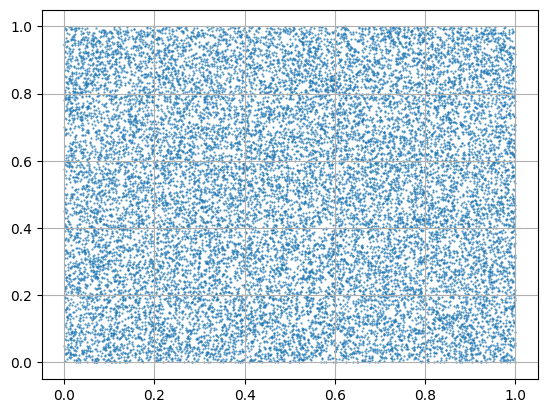

In [7]:
# simulate multivariate copula data from bicop
V_mvcp = sim_vcp_from_bcp(
    bcp_tvc=tvc.bicop.Gumbel, num_sim=20000, num_dim=7, device=DEVICE
)
# visualize first two dim
plt.scatter(*V_mvcp[:, -2:].T.cpu(), s=0.3, alpha=0.8)
plt.grid()

factory function


In [3]:
# make a DataVineCop object (from fitting the vinecop obs)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, tpl_fam=("Clayton",))
print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 20_000,
 'num_par': 21,
 'negloglik': -154425.3331,
 'aic': -308808.6663,
 'bic': -308642.693,
 'matrix': '[[ 2  5  4  6  0  1  3]'
           ' [-1  3  5  4  6  0  1]'
           ' [-1 -1  1  5  4  6  0]'
           ' [-1 -1 -1  0  5  4  6]'
           ' [-1 -1 -1 -1  5  6  4]'
           ' [-1 -1 -1 -1 -1  4  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [2, 3, 1, 0, 5, 4, 6]}


dataclass: "draw_lv"


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 2, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x1c1db03ed70>)

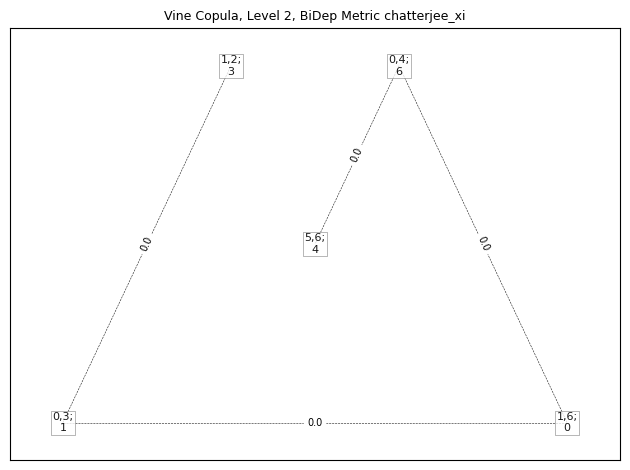

In [4]:
# for a certain level, draw the MST (of bcp) or the link between pseudo-obs
mdl_vcp.draw_lv(lv=2)

dataclass: "cdf", "l_pdf"


In [5]:
for _ in ("cdf", "l_pdf"):
    print(f"{_}\t{mdl_vcp.__getattribute__(_)(V_mvcp)}")

cdf	tensor([[0.0425],
        [0.0260],
        [0.0000],
        ...,
        [0.0342],
        [0.0014],
        [0.0061]], device='cuda:0')
l_pdf	tensor([[9.3730],
        [2.8895],
        [7.2630],
        ...,
        [5.5823],
        [6.8880],
        [7.9721]], device='cuda:0', dtype=torch.float64)


IO


In [6]:
import os

file = mdl_vcp.vcp_to_json()
print(file)
print(f"json IO? {mdl_vcp == tvc.vinecop.vcp_from_json(file)}")
os.remove(file)
file = mdl_vcp.vcp_to_pkl()
print(file)
print(f"pkl IO? {mdl_vcp == tvc.vinecop.vcp_from_pkl(file)}")
os.remove(file)

vcp.json
json IO? True
vcp.pkl
pkl IO? True


draw_dag and cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 20_000,
 'num_par': 6,
 'negloglik': -154422.9352,
 'aic': -308833.8705,
 'bic': -308786.4495,
 'matrix': '[[ 2  6  5  1  4  3  0]'
           ' [-1  5  6  1  4  3  0]'
           ' [-1 -1  1  6  4  3  0]'
           ' [-1 -1 -1  4  6  3  0]'
           ' [-1 -1 -1 -1  3  6  0]'
           ' [-1 -1 -1 -1 -1  0  6]'
           ' [-1 -1 -1 -1 -1 -1  6]]',
 'lst_sim': [2, 6, 5, 1, 4, 3, 0]}


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x1c1db2412d0>)

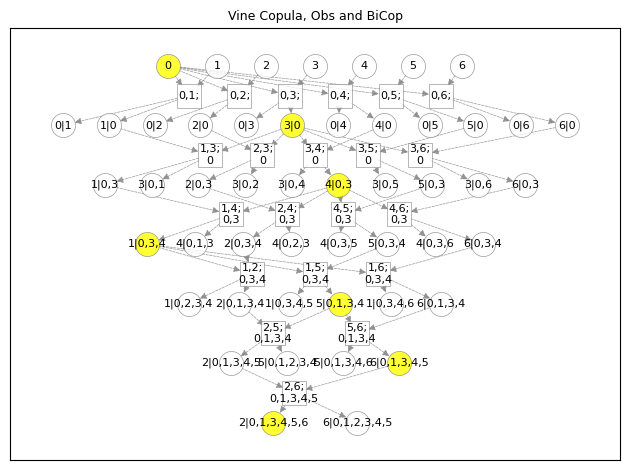

In [7]:
# give lst_first to prioritize, show the default sim workflow (source vertices highlighted)
lst_first = [3, 0]
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, cdrvine="cvine", lst_first=lst_first)
print(mdl_vcp)
mdl_vcp.draw_dag()

In [8]:
# by default, a full simulation
mdl_vcp.sim(num_sim=10000, device=DEVICE)

tensor([[0.8805, 0.8730, 0.9401,  ..., 0.7129, 0.7148, 0.6613],
        [0.5873, 0.6031, 0.8992,  ..., 0.6570, 0.6437, 0.0384],
        [0.3703, 0.3576, 0.3980,  ..., 0.5426, 0.5235, 0.2067],
        ...,
        [0.7913, 0.7941, 0.4142,  ..., 0.5480, 0.5500, 0.9226],
        [0.4345, 0.3883, 0.7917,  ..., 0.4669, 0.4665, 0.2382],
        [0.2341, 0.2054, 0.7024,  ..., 0.9380, 0.9360, 0.9539]],
       device='cuda:0', dtype=torch.float64)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x1bf826f69b0>)

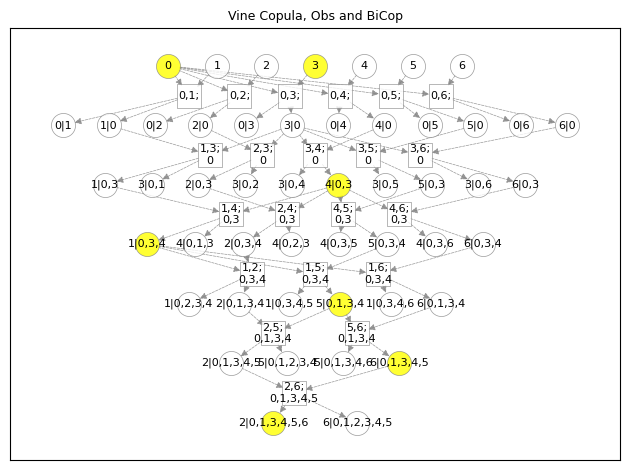

In [9]:
# show the sim workflow with lst_first taken as simulated (source vertices highlighted), a cond sim
lst_first = [3, 0]
mdl_vcp.draw_dag(lst_first=lst_first)

In [10]:
# prepare dct_first for a cond sim
num_sim = 10000
lst_obs = [0.7, 0.3]
dct_first = {
    idx: torch.ones(size=(num_sim, 1), device=DEVICE) * lst_obs[i]
    for i, idx in enumerate(lst_first)
}
for k, v in dct_first.items():
    print(k, v)

3 tensor([[0.7000],
        [0.7000],
        [0.7000],
        ...,
        [0.7000],
        [0.7000],
        [0.7000]], device='cuda:0')
0 tensor([[0.3000],
        [0.3000],
        [0.3000],
        ...,
        [0.3000],
        [0.3000],
        [0.3000]], device='cuda:0')


In [11]:
# NOTE cond sim: corresponding columns are preserved.
mdl_vcp.sim(num_sim=10000, dct_first=dct_first, device=DEVICE)

tensor([[0.3000, 0.3421, 0.7021,  ..., 0.8805, 0.8841, 0.0693],
        [0.3000, 0.3045, 0.7054,  ..., 0.6647, 0.6683, 0.8912],
        [0.3000, 0.2827, 0.6944,  ..., 0.8501, 0.8312, 0.8866],
        ...,
        [0.3000, 0.2961, 0.7089,  ..., 0.1674, 0.1203, 0.1935],
        [0.3000, 0.3008, 0.7287,  ..., 0.3876, 0.3552, 0.1731],
        [0.3000, 0.2978, 0.6942,  ..., 0.9822, 0.9822, 0.8353]],
       device='cuda:0', dtype=torch.float64)

timeit


In [12]:
import math
import pyvinecopulib as pvc

ctrls = pvc.FitControlsVinecop(
    family_set=[
        pvc.BicopFamily.clayton,
        pvc.BicopFamily.gumbel,
        pvc.BicopFamily.frank,
        pvc.BicopFamily.joe,
        pvc.BicopFamily.gaussian,
        pvc.BicopFamily.indep,
    ],
    parametric_method="itau",
    tree_criterion="tau",
    selection_criterion="aic",
)
lst_num_dim = [20, 40, 60, 80, 100]
for num_dim in lst_num_dim:
    num_sim = int(100 * num_dim ** (math.expm1(1)))
    print(f"\n{num_dim=}, {num_sim=}")
    V_mvcp = sim_vcp_from_bcp(
        bcp_tvc=tvc.bicop.Gaussian, num_dim=num_dim, device=DEVICE
    )
    mdl_vcp = tvc.vinecop.vcp_from_obs(
        V_mvcp,
        mtd_fit="itau",
        mtd_bidep="kendall_tau",
        mtd_sel="aic",
        tpl_fam=("Clayton", "Gumbel", "Frank", "Joe", "Gaussian", "Independent"),
    )
    mdl_vcp_pvc = pvc.Vinecop(data=V_mvcp.cpu(), controls=ctrls)
    %timeit mdl_vcp.sim(num_sim=num_sim, device=DEVICE, dtype=torch.float64)
    %timeit mdl_vcp_pvc.simulate(n=num_sim, num_threads=8)


num_dim=20, num_sim=17200
316 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
222 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=40, num_sim=56596
1.02 s ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.99 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=60, num_sim=113596
2.74 s ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.6 s ± 70 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=80, num_sim=186227
6.5 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.4 s ± 319 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=100, num_sim=273252
15.3 s ± 75.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 34s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
